# py_lqr-qp.ipynb

## Lecture 8 of CMU16-745 (2025)
Created: Feb 25, 25

Julia version from class uses SparseArrays. I'm gonna mess around with scipy.sparse.
It turns out a bit tricky. I need to switch sparse format from time to time to make it work. 

In [92]:
import numpy as np 
import matplotlib.pyplot as plt 
#from numpy.linalg import solve
import scipy as sp
from scipy.sparse.linalg import  spsolve
from scipy.sparse import kron

In [93]:
# Discrete dynamics
h = 0.1  # time step
A = sp.sparse.lil_array([[1,h],[0,1]])
B = sp.sparse.lil_array([[0.5*h*h],[h]])

In [94]:
n = 2     # number of state
m = 1     # number of controls
Tfinal = 10.0 # final time #try larger values
N = int(Tfinal/h)+1    # number of time steps
thist = np.arange(0,h*(N-1),h)

In [95]:
# Initial condiations
x0 = sp.sparse.csc_array([[1.0],[0]])

In [96]:
# Cost weights
Q = 1.0*sp.sparse.identity(2,format='lil')
R = 0.1*sp.sparse.lil_array([[1]])
#Rmat = np.array(R).reshape(1,1)  # used in solve
Qn = sp.sparse.identity(2,format='lil')

In [97]:
def J(xhist, uhist):
    xend = xhist[:,-1]
    cost = 0.5*xend.T@Qn@xend
    for k in range(N-1):
        xk = xhist[:,k]
        uk = uhist[k]
        cost = cost + 0.5*xk.T@Q.toarray()@xk + 0.5*uk*R.toarray()*uk
    return cost

In [98]:
H = sp.sparse.block_diag((R,kron(sp.sparse.identity(N-2,format='lil'),sp.sparse.block_diag((Q,R))),Qn))

In [99]:
# Constraints
C = kron(sp.sparse.identity(N-1,format='lil'),sp.sparse.hstack((B,-sp.sparse.identity(2,format='lil'))))
C = sp.sparse.lil_array(C)
for k in range(1,N-1):
    C[(k*n):(k*n)+n,k*(n+m)-n:k*(n+m)] = A # this operation prefers sparse 'lil' or 'dok' type
d = sp.sparse.vstack((-A@x0, sp.sparse.lil_array(np.zeros((C.shape[0]-n,1)))))

In [100]:
# Solve the linear system G*y = w --> y = solve(G,w)
# where G = [H C';C 0], y = [z; lambda], w = [0; d]
G = sp.sparse.vstack((sp.sparse.hstack((H,C.T)),sp.sparse.hstack((C,sp.sparse.lil_array(np.zeros((C.shape[0],C.shape[0])))))))
w = sp.sparse.vstack((np.zeros((H.shape[0],1)), d))
G = sp.sparse.csc_array(G) # solve requires sparse 'csr' or 'csc' type
w = sp.sparse.csc_array(w)
y = spsolve(G,w)

# Get state history
z = y[0:H.shape[0]] # states and controls [u0, x1, u1, ..., xN] where uk is scalar and xk is (2,1)
Z = z.reshape(N-1,n+m).T
xhist = Z[m:n+m,:]
uhist = Z[0,:]

xhist = np.hstack((x0.toarray(),xhist))



In [101]:
J(xhist,uhist)

array([[6.65861221]])

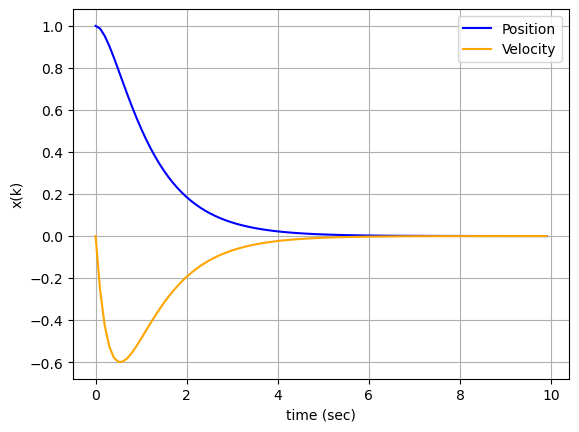

In [102]:
# plot results
plt.figure()
plt.plot(thist,xhist[0,0:N-1],"b-",thist,xhist[1,0:N-1],'orange')
plt.xlabel("time (sec)")
plt.ylabel("x(k)")
plt.legend(["Position","Velocity"])
plt.grid(True)
plt.show()


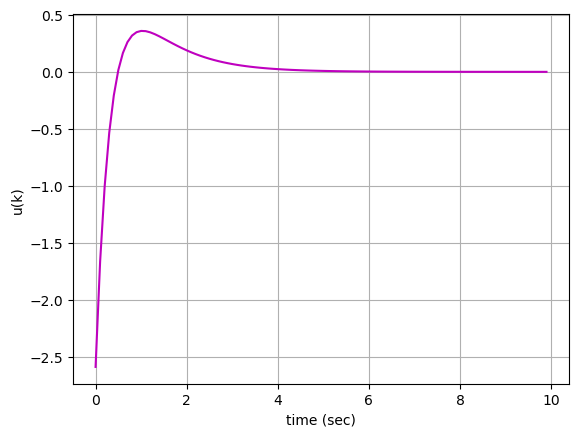

In [103]:
plt.figure()
plt.plot(thist,uhist,"m-")
plt.xlabel("time (sec)")
plt.ylabel("u(k)")
plt.grid(True)
plt.show()